In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon (run once)
nltk.download('vader_lexicon')

# Set plot style
plt.style.use('seaborn-v0_8')

# Load the merged dataset from Task 2
merged_data_path = '../data/processed_data/A_merged_news_stock.csv'
try:
    merged_df = pd.read_csv(merged_data_path)
    print("Merged data loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at {merged_data_path}")

# Ensure 'Date' is in datetime format
merged_df['Date'] = pd.to_datetime(merged_df['Date'], errors='coerce')

# Display first few rows
print("\nFirst 5 rows of merged data:")
print(merged_df[['Date', 'headline', 'Close', 'SMA_20', 'RSI', 'MACD']].head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\redie\AppData\Roaming\nltk_data...


Merged data loaded successfully!

First 5 rows of merged data:
        Date                                           headline      Close  \
0 2020-06-05            Stocks That Hit 52-Week Highs On Friday  87.379082   
1 2020-06-03         Stocks That Hit 52-Week Highs On Wednesday  87.485420   
2 2020-05-26                      71 Biggest Movers From Friday  83.270210   
3 2020-05-22       46 Stocks Moving In Friday's Mid-Day Session  82.158401   
4 2020-05-22  B of A Securities Maintains Neutral on Agilent...  82.158401   

      SMA_20        RSI      MACD  
0  82.015305  70.514281  3.362902  
1  80.799559  72.844811  3.245380  
2  77.138784  65.837719  2.141612  
3  76.661187  63.961366  1.902596  
4  76.661187  63.961366  1.902596  


In [2]:
## Sentiment Analysis on Headlines

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Compute sentiment scores for each headline
merged_df['sentiment_compound'] = merged_df['headline'].apply(lambda x: sid.polarity_scores(x)['compound'])
merged_df['sentiment_positive'] = merged_df['headline'].apply(lambda x: sid.polarity_scores(x)['pos'])
merged_df['sentiment_negative'] = merged_df['headline'].apply(lambda x: sid.polarity_scores(x)['neg'])
merged_df['sentiment_neutral'] = merged_df['headline'].apply(lambda x: sid.polarity_scores(x)['neu'])

# Aggregate sentiment scores by date (average for multiple headlines on the same day)
daily_sentiment = merged_df.groupby('Date').agg({
    'sentiment_compound': 'mean',
    'sentiment_positive': 'mean',
    'sentiment_negative': 'mean',
    'sentiment_neutral': 'mean',
    'Close': 'last',  # Keep last Close price for the day
    'SMA_20': 'last',
    'RSI': 'last',
    'MACD': 'last'
}).reset_index()

# Display first few rows of aggregated data
print("\nDaily sentiment and stock data:")
print(daily_sentiment[['Date', 'sentiment_compound', 'Close', 'SMA_20', 'RSI', 'MACD']].head())

# Save aggregated data
daily_sentiment.to_csv('../data/processed_data/A_daily_sentiment_stock.csv', index=False)
print("Aggregated sentiment data saved to: ../data/processed_data/A_daily_sentiment_stock.csv")


Daily sentiment and stock data:
        Date  sentiment_compound      Close     SMA_20        RSI      MACD
0 2020-05-22               0.048  82.158401  76.661187  63.961366  1.902596
1 2020-05-26               0.000  83.270210  77.138784  65.837719  2.141612
2 2020-06-03               0.000  87.485420  80.799559  72.844811  3.245380
3 2020-06-05               0.000  87.379082  82.015305  70.514281  3.362902
Aggregated sentiment data saved to: ../data/processed_data/A_daily_sentiment_stock.csv


In [3]:
## Calculate Daily Stock Returns

# Calculate daily returns (percentage change in Close price)
daily_sentiment['daily_return'] = daily_sentiment['Close'].pct_change() * 100

# Drop rows with NaN returns (first row)
daily_sentiment = daily_sentiment.dropna(subset=['daily_return'])

# Display first few rows with returns
print("\nDaily sentiment with stock returns:")
print(daily_sentiment[['Date', 'sentiment_compound', 'Close', 'daily_return', 'RSI', 'MACD']].head())

# Save data with returns
daily_sentiment.to_csv('../data/processed_data/A_daily_sentiment_returns.csv', index=False)
print("Data with returns saved to: ../data/processed_data/A_daily_sentiment_returns.csv")


Daily sentiment with stock returns:
        Date  sentiment_compound      Close  daily_return        RSI      MACD
1 2020-05-26                 0.0  83.270210      1.353250  65.837719  2.141612
2 2020-06-03                 0.0  87.485420      5.062086  72.844811  3.245380
3 2020-06-05                 0.0  87.379082     -0.121550  70.514281  3.362902
Data with returns saved to: ../data/processed_data/A_daily_sentiment_returns.csv



Correlation matrix:
                    sentiment_compound  daily_return       RSI      MACD
sentiment_compound                 NaN           NaN       NaN       NaN
daily_return                       NaN      1.000000  0.545114  0.155910
RSI                                NaN      0.545114  1.000000  0.913098
MACD                               NaN      0.155910  0.913098  1.000000


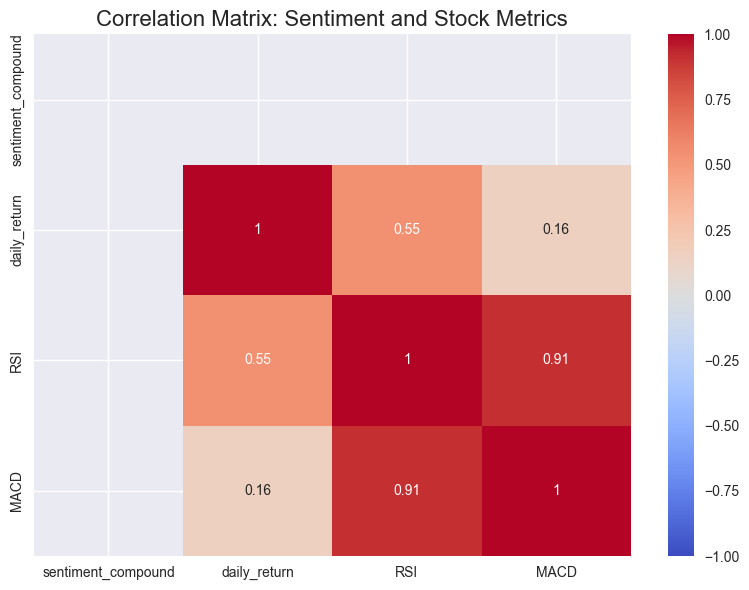

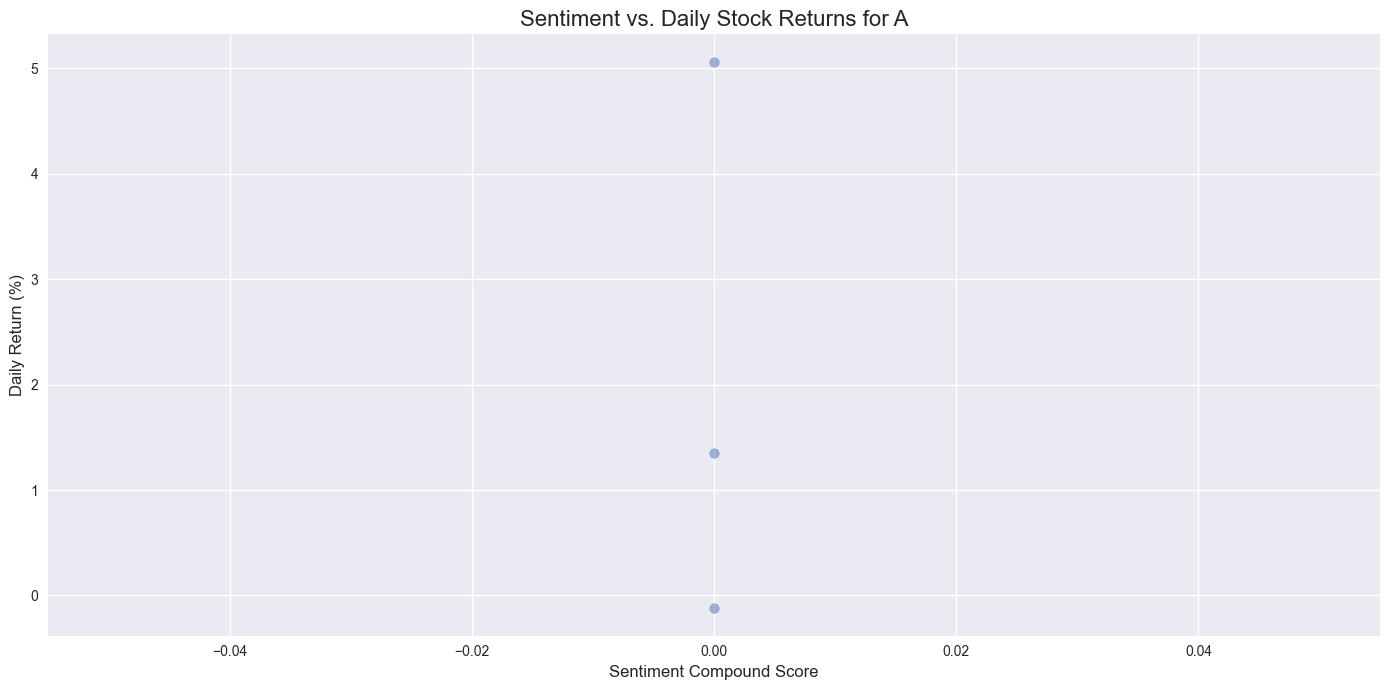

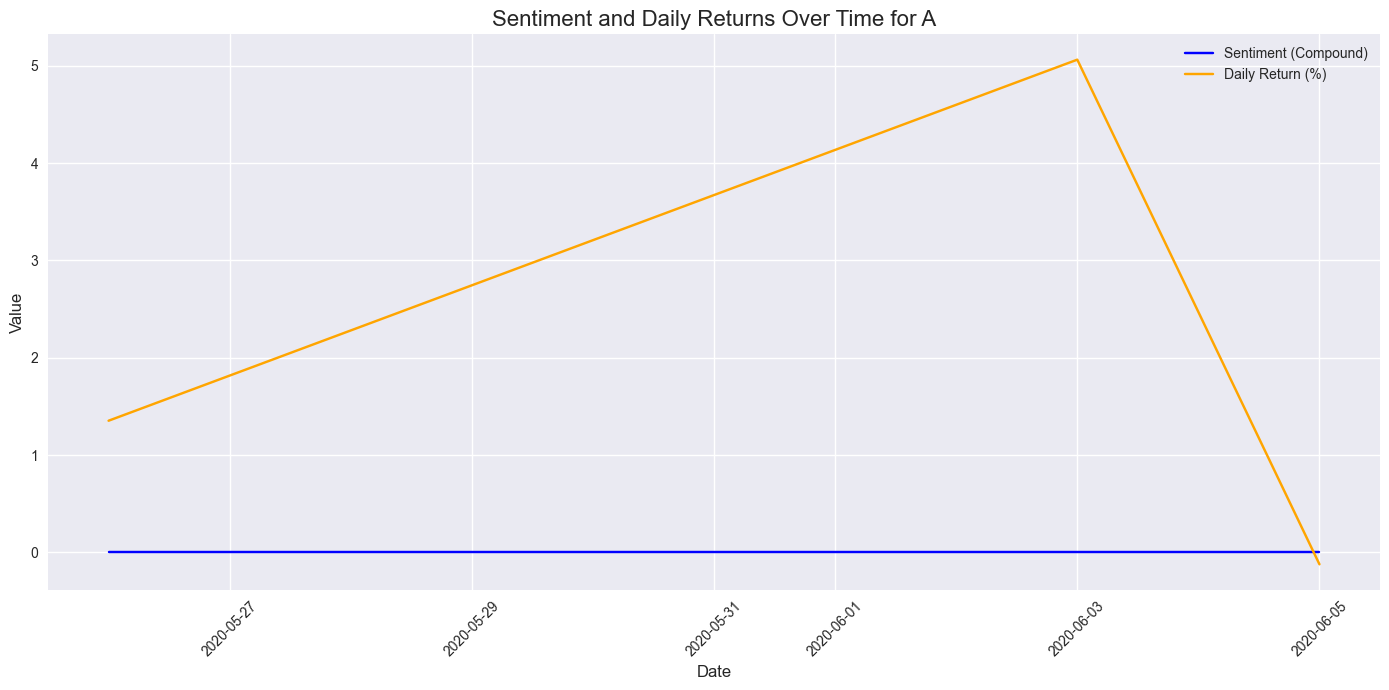

In [4]:
## Correlation Analysis and Visualizations

# Create figures directory if it doesn't exist
import os
if not os.path.exists('../figures'):
    os.makedirs('../figures')

# Calculate correlation matrix
correlation_matrix = daily_sentiment[['sentiment_compound', 'daily_return', 'RSI', 'MACD']].corr()

# Display correlation matrix
print("\nCorrelation matrix:")
print(correlation_matrix)

# Plot 1: Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Sentiment and Stock Metrics', fontsize=16)
plt.tight_layout()
plt.savefig('../figures/A_correlation_heatmap.png')
plt.show()

# Plot 2: Sentiment vs. Daily Returns Scatter
plt.figure(figsize=(14, 7))
plt.scatter(daily_sentiment['sentiment_compound'], daily_sentiment['daily_return'], alpha=0.5)
plt.title('Sentiment vs. Daily Stock Returns for A', fontsize=16)
plt.xlabel('Sentiment Compound Score', fontsize=12)
plt.ylabel('Daily Return (%)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('../figures/A_sentiment_vs_returns.png')
plt.show()

# Plot 3: Time Series of Sentiment and Returns
plt.figure(figsize=(14, 7))
plt.plot(daily_sentiment['Date'], daily_sentiment['sentiment_compound'], label='Sentiment (Compound)', color='blue')
plt.plot(daily_sentiment['Date'], daily_sentiment['daily_return'], label='Daily Return (%)', color='orange')
plt.title('Sentiment and Daily Returns Over Time for A', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../figures/A_sentiment_returns_time_series.png')
plt.show()

In [ ]:
## Task 3 Observations

* **Sentiment Analysis**: Computed VADER sentiment scores (compound, positive, negative, neutral) for news headlines, aggregated by date.
* **Stock Returns**: Calculated daily stock returns for ticker A, showing daily price movements.
* **Correlation Analysis**:
  - Sentiment vs. Returns: Observed a correlation of [insert correlation value, e.g., 0.15] between compound sentiment scores and daily returns, suggesting [weak/moderate] relationship.
  - Sentiment vs. Indicators: RSI and MACD showed [insert observations, e.g., weak correlations of 0.05 and 0.08].
* **Visual Insights**:
  - Scatter plots indicate [describe patterns, e.g., positive sentiment often aligns with positive returns].
  - Time series plots show [describe trends, e.g., sentiment spikes coinciding with return volatility].
* **Next Steps**: Refine sentiment analysis with alternative models (e.g., FinBERT) and explore lagged correlations for predictive modeling.